# Mouse 5' UTR Outlier Analysis

We decided to remove the transcript **Mettl26** from our reference.

In [7]:
import ribopy

import matplotlib

from matplotlib import pyplot as plt

from ribopy.core.get_gadgets import get_region_boundaries

import pandas as pd
import numpy as np

from functools import partial

import gzip

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 5]

colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']

In [4]:
ribo_path = "../mouse-itp_v2.ribo"
myribo    = ribopy.Ribo(ribo_path, alias=ribopy.api.alias.apris_human_alias)

In [5]:
myribo.print_info()

Ribo File Info:
---------------
Ribo File Version : 1.0
RiboPy Version    : 0.0.1
Creation Time     : 2021-06-09 18:15:52
Reference         : mouse-v2
Min Read Length   : 15
Max Read Length   : 40
Metagene Radius   : 50
Left Span         : 35
Right Span        : 10

Experiments:
------------ 
Name                            Reads  Coverage  RNA-Seq  Metadata
20210513-ITP-1cell-cross-50-A  268026         *                   
20210513-ITP-1cell-cross-50-B  261155         *                   
20210513-ITP-1cell-cross-50-C  186444         *                   
20210513-ITP-1cell-cross-50-D  256510         *                   
20210513-ITP-1cell-cross-50-E  343066         *                   
20210513-ITP-2cell-cross-50-B  298249         *                   
20210513-ITP-2cell-cross-50-C  206541         *                   
20210513-ITP-2cell-cross-50-F  268902         *                   
20210513-ITP-4cell-cross-50-B  567771         *                   
20210513-ITP-4cell-cross-50-C  36252

In [12]:
LENGTH_MIN = 29
LENGTH_MAX = 35

In [14]:
from ribopy.core.get_gadgets import get_region_boundaries

def rename(x):
    return x.split("|")[4]

def get_coverage(ribo, 
                 experiment,
                 range_lower = 0,
                 range_upper = 0,
                 alias       = False,
                 multiplier  = 1):
    """
    NOTE THAT THIS FUNCTION RETURNS A TUPLE!!!
    
    Returns a pair: (dataframe, coverage_dict)
    
    In the dataframe, the last column 
    has the coverage density of a given transcript.
    The normalized covarage is defined by
    (#total_reads / #transcript_length) * 1000000
    
    coverage_dict: This is the output of the function "get_coverage"
    of the ribo object. It contains the coverage values of each gene 
    at nucleotide resolution.

    """
    
    coverage_dict = ribo.get_coverage(experiment  = experiment,
                                      range_lower = range_lower, 
                                      range_upper = range_upper,
                                      alias       = alias)
    
    region_boundaries = get_region_boundaries(ribo._handle)
    
    transcript_names     = coverage_dict.keys()
    transcript_coverages = coverage_dict.values()
    transcript_total     = tuple( map( np.sum, transcript_coverages ) )
    transcript_lengths   = tuple( map(len, transcript_coverages) )
    normalized_coverage  = np.divide(transcript_total , transcript_lengths) * multiplier
    start_sites          = tuple( map( lambda x: x[1][0], region_boundaries ) )
    stop_sites           = tuple( map( lambda x: x[1][1], region_boundaries ) )
    
    # We also add normalized cds coverage
    cds_data = zip( start_sites, stop_sites, transcript_coverages )
    norm_cds = tuple( map( lambda x:  
                              (np.sum( x[2][x[0]:x[1]] ) / (x[1] - x[0]) )* multiplier,
                      cds_data) )
    
    result = pd.DataFrame(data = { "total"     :  transcript_total, 
                                   "length"    :  transcript_lengths,
                                   "cds_start" :  start_sites,
                                   "cds_stop"  :  stop_sites,
                                   "norm_cds"  :  norm_cds,
                                   "norm_cov"  :  normalized_coverage}, 
                          index = transcript_names) 
    
    return( (result, coverage_dict))

In [15]:
coverages = { e: get_coverage(
                     ribo        = myribo, 
                     experiment  = e,
                     range_lower = LENGTH_MIN,
                     range_upper = LENGTH_MAX,
                     alias       = rename)\
                 for e in myribo.experiments }

In [39]:
def plot_gene(experiment_name, gene_name, highlight = False):
    gene_coverage = coverages[experiment_name][1][gene_name]

    cds_start = coverages[experiment_name][0].loc[gene_name]["cds_start"]
    cds_end   = coverages[experiment_name][0].loc[gene_name]["cds_stop"]

    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.plot(gene_coverage, color = '#D55E00')
    plt.title(gene_name)
    
    if highlight:
        ax.fill_between( highlight ,y1 = max( gene_coverage ), color = "#BF5700", alpha = 0.2)
        
    ax.fill_between([cds_start, cds_end], y1 = max( gene_coverage ), alpha = 0.2);
    return fig

In [23]:
myribo.experiments[:7]

('20210513-ITP-1cell-cross-50-A',
 '20210513-ITP-1cell-cross-50-B',
 '20210513-ITP-1cell-cross-50-C',
 '20210513-ITP-1cell-cross-50-D',
 '20210513-ITP-1cell-cross-50-E',
 '20210513-ITP-2cell-cross-50-B',
 '20210513-ITP-2cell-cross-50-C')

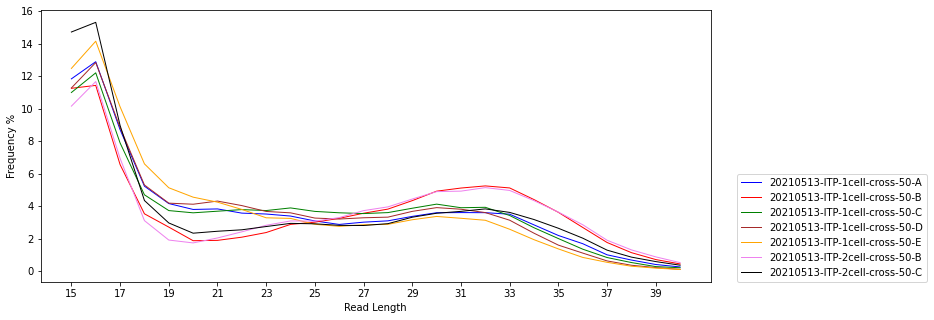

In [24]:
myribo.plot_lengthdist(region_type="CDS",experiments=myribo.experiments[:7], normalize = "True")

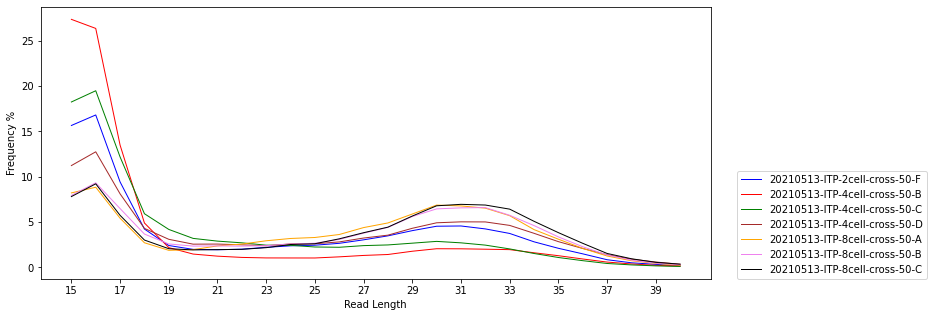

In [21]:
myribo.plot_lengthdist(region_type="CDS",experiments=myribo.experiments[7:14], normalize = "True")

In [26]:
utr5_total_region_counts = myribo.get_region_counts(
                              experiments    = myribo.experiments,
                              region_name    = "UTR5",
                              range_lower    = LENGTH_MIN,
                              range_upper    = LENGTH_MAX,
                              alias          = True,                            
                              sum_lengths    = True,
                              sum_references = False)

In [27]:
utr5_total_region_counts

,20210513-ITP-1cell-cross-50-A,20210513-ITP-1cell-cross-50-B,20210513-ITP-1cell-cross-50-C,20210513-ITP-1cell-cross-50-D,20210513-ITP-1cell-cross-50-E,20210513-ITP-2cell-cross-50-B,20210513-ITP-2cell-cross-50-C,20210513-ITP-2cell-cross-50-F,20210513-ITP-4cell-cross-50-B,20210513-ITP-4cell-cross-50-C,20210513-ITP-4cell-cross-50-D,20210513-ITP-8cell-cross-50-A,20210513-ITP-8cell-cross-50-B,20210513-ITP-8cell-cross-50-C,20210513-ITP-8cell-cross-50-D
transcript,,,,,,,,,,,,,,,
Xkr4-201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Rp1-202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sox17-201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mrpl15-206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lypla1-201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Atp6-201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mt-Nd3-201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mt-Nd4l-201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


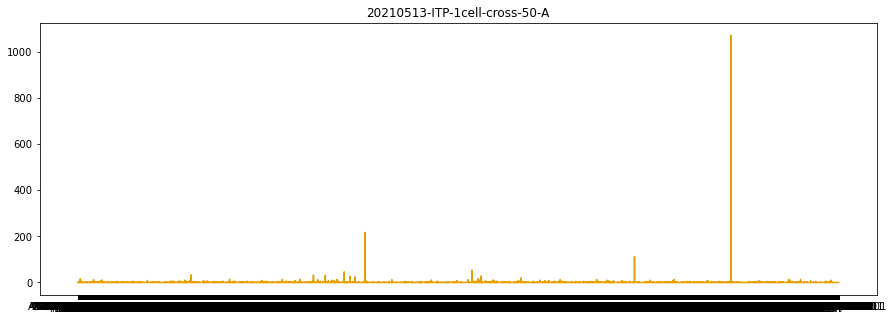

In [30]:
this_experiment = myribo.experiments[0]

x1 = utr5_total_region_counts[this_experiment]
plt.plot(x1, color = colors[0]);
plt.title(this_experiment);

In [35]:
this_experiment   = myribo.experiments[0]
top_counts_1_cell = utr5_total_region_counts[this_experiment].sort_values(ascending=False)[:20]

top_counts_1_cell

transcript
Mettl26-201          1072
Lipe-201              217
Zbed3-202             112
Btg4-201               54
E330021D16Rik-203      46
Siah2-201              33
Bpgm-201               32
Gm20594-201            31
Omt2a-203              28
Rfpl4-201              27
Obox5-201              24
Lum-201                20
Rbpms2-201             17
Khdc1b-201             16
Gda-201                14
Dtx2-201               14
Rad23b-201             14
Ankrd17-201            13
Azin1-201              13
Klhdc2-201             13
Name: 20210513-ITP-1cell-cross-50-A, dtype: uint32

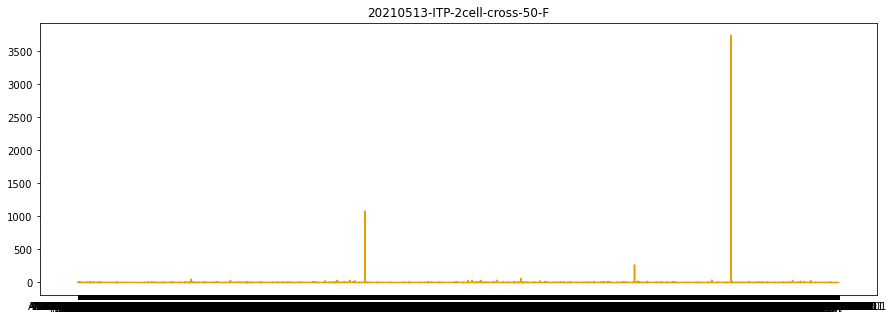

In [31]:
this_experiment = "20210513-ITP-2cell-cross-50-F"

x1 = utr5_total_region_counts[this_experiment]
plt.plot(x1, color = colors[0]);
plt.title(this_experiment);

In [36]:
this_experiment   = "20210513-ITP-2cell-cross-50-F"
top_counts_2_cell = utr5_total_region_counts[this_experiment].sort_values(ascending=False)[:20]

top_counts_2_cell

transcript
Mettl26-201    3742
Lipe-201       1080
Zbed3-202       266
Lum-201          63
Siah2-201        50
Dppa2-202        37
Rfpl4-201        34
Armt1-201        34
Btg4-201         34
Omt2a-203        33
Shoc1-201        32
Lgi1-207         32
Dppa3-201        31
Grik4-202        31
Usp26-202        30
Gm20594-201      28
Ebf1-201         24
Gpbp1-201        23
Bcl2l10-201      23
Obox5-201        21
Name: 20210513-ITP-2cell-cross-50-F, dtype: uint32

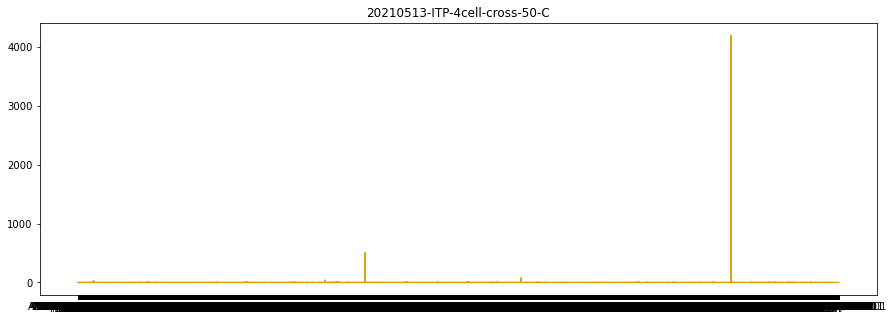

In [32]:
this_experiment = "20210513-ITP-4cell-cross-50-C"

x1 = utr5_total_region_counts[this_experiment]
plt.plot(x1, color = colors[0]);
plt.title(this_experiment);

In [37]:
this_experiment   = "20210513-ITP-4cell-cross-50-C"
top_counts_4_cell = utr5_total_region_counts[this_experiment].sort_values(ascending=False)[:20]

top_counts_4_cell

transcript
Mettl26-201     4203
Lipe-201         505
Lum-201           79
Gm20594-201       41
Sp110-201         32
Gpbp1-201         18
Grik4-202         14
Zfand5-205        14
Olfr1217-204      13
Dppa3-201         13
Usp26-202         13
Snrpc-203         11
Armt1-201         11
Nudt4-201         10
Wnk1-202           9
Xpo1-202           9
Smarca5-201        8
Ebf1-201           8
Grcc10-201         8
Pabpc4-202         8
Name: 20210513-ITP-4cell-cross-50-C, dtype: uint32

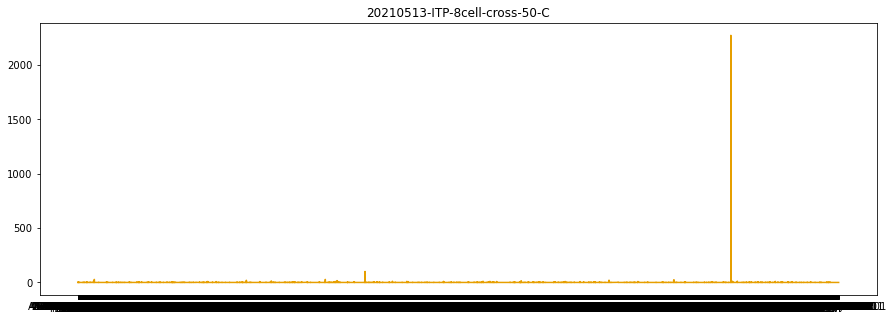

In [33]:
this_experiment = "20210513-ITP-8cell-cross-50-C"

x1 = utr5_total_region_counts[this_experiment]
plt.plot(x1, color = colors[0]);
plt.title(this_experiment);

In [38]:
this_experiment = "20210513-ITP-8cell-cross-50-C"

top_counts_8_cell = utr5_total_region_counts[this_experiment].sort_values(ascending=False)[:20]

top_counts_8_cell

transcript
Mettl26-201    2272
Lipe-201        101
Gm20594-201      28
Alppl2-201       28
Azin1-201        24
Eif5-202         21
Pabpc4-202       20
Pabpc1-201       19
Dppa3-201        17
Lum-201          15
Sp110-201        14
Slc5a6-202       14
Brd2-201         12
Trim43b-201      11
Folr1-204        11
Snrpc-203        11
Cnot1-202        10
Arih2-201        10
Chka-202         10
Spns1-201        10
Name: 20210513-ITP-8cell-cross-50-C, dtype: uint32

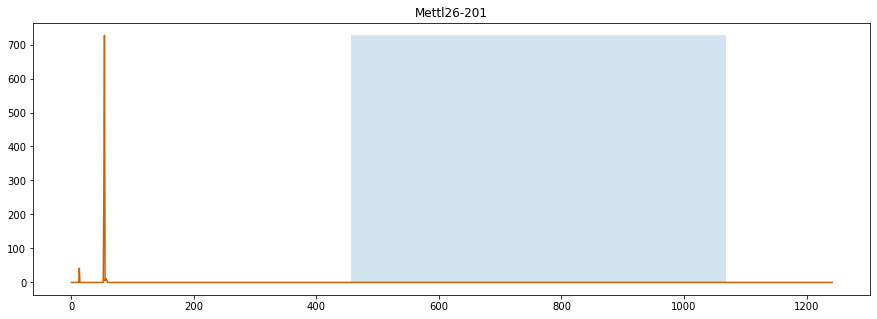

In [40]:
plot_gene(experiment_name = myribo.experiments[0], gene_name = "Mettl26-201") ;

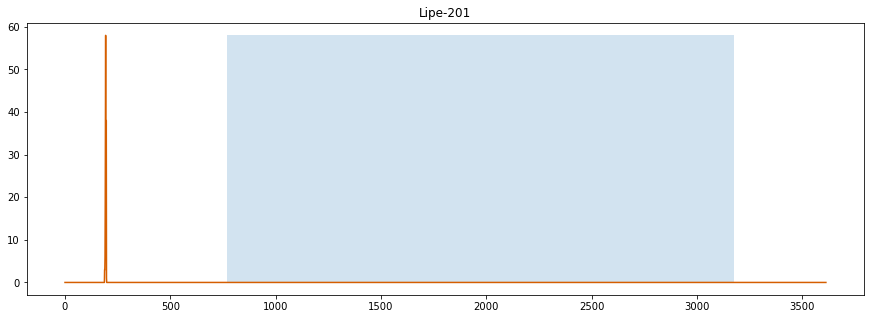

In [41]:
plot_gene(experiment_name = myribo.experiments[0], gene_name = "Lipe-201") ;

In [42]:
this_experiment = "20210513-ITP-8cell-cross-50-D"

top_counts_8_cell = utr5_total_region_counts[this_experiment].sort_values(ascending=False)[:20]

top_counts_8_cell

transcript
Mettl26-201       3116
Lipe-201           340
Gm20594-201         34
Lum-201             22
Olfr1217-204        19
Sp110-201           17
Csde1-201           16
Alppl2-201          16
Eif5-202            16
D5Ertd577e-202      14
Usp26-202           14
Eif4e-201           14
Armt1-201           13
Ebf1-201            13
Xpo1-202            13
Azin1-201           12
Lgi1-207            12
Dppa3-201           11
Slc5a6-202          11
Dppa2-202           11
Name: 20210513-ITP-8cell-cross-50-D, dtype: uint32